# **Construcción de modelo Extra Trees Classifier**

# **Importación de librerías necesarias** 

In [30]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from scipy.stats import randint as sp_randint

# **Carga de los datos**

In [31]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
X_train = train.drop('class', axis=1)
y_train = train['class'].copy()
X_test = test.drop('class', axis=1)
y_test = test['class'].copy()

# **Optimización de hiperparámetros** 

## **Inicialización del modelo ExtraTreesClassifier**

In [32]:
rf = ExtraTreesClassifier(n_estimators=50)

## **Configuración del entorno de la búsqueda**

In [33]:
# Definiendo los dominios de los hiperparámetros
param_dist = {"max_depth": [3, 9, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

In [34]:
# Numeros de muestras del espacio de hiperparametros a generar
samples = 50
randomCV = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=samples,cv=3)

## **Búsqueda aleatoria de hiperparámetros**

In [35]:
randomCV.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=ExtraTreesClassifier(n_estimators=50),
                   n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 9, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000000025895510>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000000000D4CA250>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000000258D2110>})

In [36]:
#Mostrando los mejores parametros obtenidos
print(randomCV.best_params_)

{'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 3, 'min_samples_split': 4}


In [37]:
randomCV.cv_results_['mean_test_score']

array([0.85138999, 0.86611385, 0.8546085 , 0.73544682, 0.87987898,
       0.73469428, 0.73044874, 0.87987904, 0.73893944, 0.82885919,
       0.88076941, 0.76263446, 0.84919825, 0.77338639, 0.87344157,
       0.76373108, 0.84440467, 0.85323899, 0.75469076, 0.73257046,
       0.85426607, 0.88029002, 0.73702214, 0.68908368, 0.74229406,
       0.74133591, 0.83303588, 0.8479659 , 0.74873211, 0.75660741,
       0.89063084, 0.8651551 , 0.66696452, 0.84091147, 0.77653707,
       0.76290843, 0.8541979 , 0.76284046, 0.72702491, 0.86186813,
       0.74695236, 0.84173374, 0.73715986, 0.68148309, 0.82700938,
       0.88501533, 0.6899743 , 0.76023853, 0.88734373, 0.85056797])

In [38]:
randomCV.score(X_test,y_test)

0.8897266729500471

# **Creación del modelo obtenido**

In [39]:
# Parametros obtenidos en la busqueda
params = randomCV.best_params_

In [40]:
randomCV.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 6,
 'min_samples_leaf': 3,
 'min_samples_split': 4}

## **Inicialización del modelo**

In [41]:
rf = ExtraTreesClassifier(n_estimators=500, **randomCV.best_params_)

In [42]:
rf.fit(X_train, y_train)

ExtraTreesClassifier(criterion='entropy', max_features=6, min_samples_leaf=3,
                     min_samples_split=4, n_estimators=500)

## **Predicción del modelo**

In [43]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# **Métricas del modelo** 

In [44]:
rf.score(X_test,y_test)

0.8906691800188501

In [45]:
# Accuracy
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_test_pred)

0.8906691800188501

In [46]:
# Matthew Correlation Coefficient
from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(y_test, y_test_pred)

0.787838375307917

In [47]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_test_pred)

array([[2104,   85],
       [ 379, 1676]], dtype=int64)

In [48]:
# Reporte de clasificación
from sklearn.metrics import classification_report

model_report = classification_report(y_test, y_test_pred, target_names=['positive','negative'])

f = open('extra_rf_model_report.txt','w')
f.writelines(model_report) 
f.close()

In [49]:
# Devolver la importancia de los features del modelo
importance = pd.Series(rf.feature_importances_, name = 'Gini')

# Devolver los nombre de los features
feature_names = pd.Series(X_train.columns, name = 'Feature')

In [50]:
# Combinar los nombre de los nombres de los features y los valores de Gini en un Dataframe
df = pd.concat([feature_names, importance], axis=1, names=['Feature', 'Gini'])
df

,Feature,Gini
0,AAC_A,0.005643
1,AAC_C,0.026299
2,AAC_D,0.015287
3,AAC_E,0.024750
4,AAC_F,0.006524
...,...,...
108,QSO1_SC_A,0.005006
109,QSO1_SC_K,0.016995
110,QSO1_SC_L,0.008194
111,QSO1_SC_R,0.006273


Text(0.5, 0, 'Feature Importance')

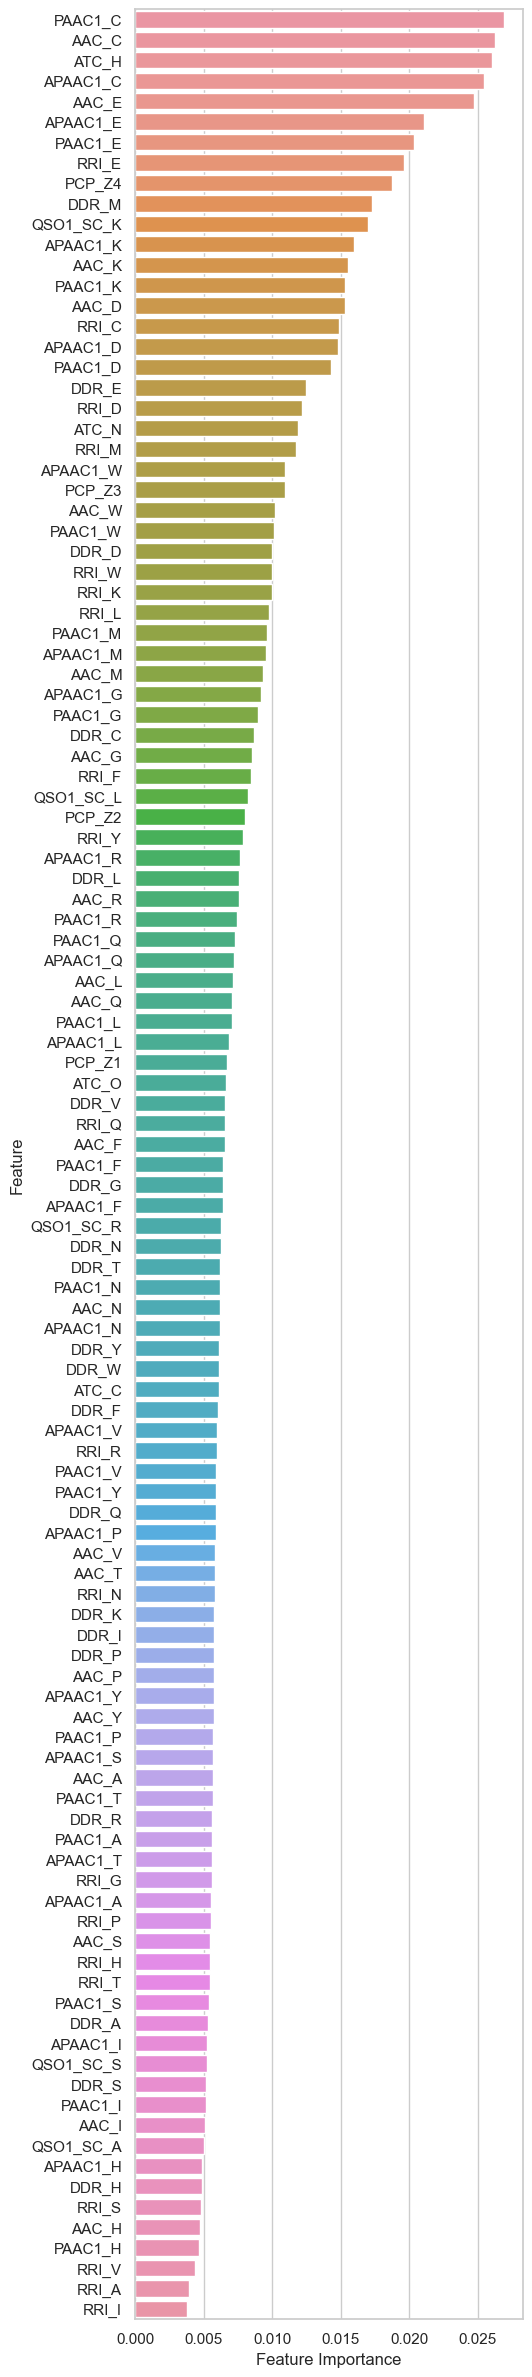

In [51]:
# Plot of feature importance
import matplotlib.pyplot as plt
import seaborn as sns

df_sorted = df.sort_values('Gini', ascending=False) # Sort by Gini in descending order; Showing only the top 20 results

plt.figure(figsize=(5, 30))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x = 'Gini', y = 'Feature', data = df_sorted)
plt.xlabel("Feature Importance")

<Axes: >

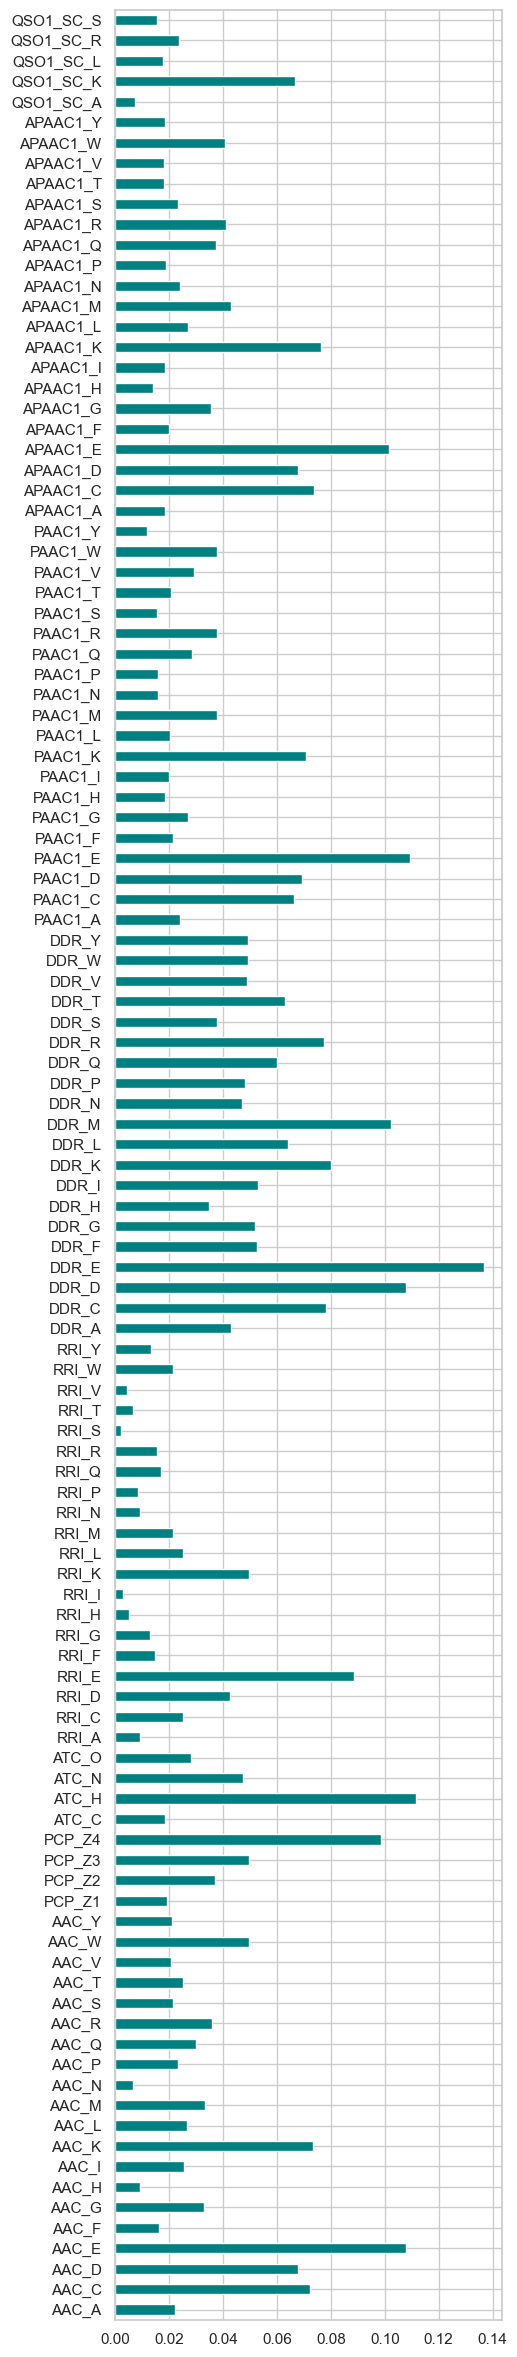

In [52]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(5, 30))
importances = mutual_info_classif(X_train, y_train)
feat_importances = pd.Series(importances, X_train.columns[0:len(X_train.columns)])
feat_importances.plot(kind='barh', color='teal')